# ISLP - Chapter 9 - Exercise 8
### Author: pzuehlke

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

As always, we begin by reading and cleaning the data:

In [2]:
oj = pd.read_csv("OJ.csv")
oj.dropna(inplace=True)
oj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Purchase        1070 non-null   object 
 1   WeekofPurchase  1070 non-null   int64  
 2   StoreID         1070 non-null   int64  
 3   PriceCH         1070 non-null   float64
 4   PriceMM         1070 non-null   float64
 5   DiscCH          1070 non-null   float64
 6   DiscMM          1070 non-null   float64
 7   SpecialCH       1070 non-null   int64  
 8   SpecialMM       1070 non-null   int64  
 9   LoyalCH         1070 non-null   float64
 10  SalePriceMM     1070 non-null   float64
 11  SalePriceCH     1070 non-null   float64
 12  PriceDiff       1070 non-null   float64
 13  Store7          1070 non-null   object 
 14  PctDiscMM       1070 non-null   float64
 15  PctDiscCH       1070 non-null   float64
 16  ListPriceDiff   1070 non-null   float64
 17  STORE           1070 non-null   i

In [3]:
oj.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


We will remove the column `Store7` from consideration since it is redundant with
the column `STORE` (besides having a datatype that would need to be converted to
work with our models).

In [4]:
X = oj.drop(columns=["Purchase", "Store7"], axis=1)
y = oj["Purchase"]

__8 (a):__ The feature matrix has $ 16 $ columns, the training sets will have $ 800 $ observations
while the test set will contain the remaining $ 270 $.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=800, random_state=0, shuffle=True
)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (800, 16)
Test set shape: (270, 16)


Since the SVC is based on the euclidean distance between observations, we should
standardize the scale of the features.

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

__8 (b):__ There are $ 429 = 215 + 214 $ support vectors for this model:

In [7]:
svc_linear = SVC(kernel="linear", C=0.01)
svc_linear.fit(X_train, y_train)

n_support_linear = svc_linear.n_support_.sum()
print(f"Number of support vectors = {n_support_linear}")
print(f"Distribution of the support vectors on either side: {svc_linear.n_support_}")

Number of support vectors = 429
Distribution of the support vectors on either side: [215 214]


__8 (c):__ The training and test error rates are $ 16.13\% $ and $ 18.89\% $,
respectively.

In [8]:
y_train_pred_linear = svc_linear.predict(X_train)
y_test_pred_linear = svc_linear.predict(X_test)

train_error_linear = 1 - accuracy_score(y_train, y_train_pred_linear)
test_error_linear = 1 - accuracy_score(y_test, y_test_pred_linear)

print(f"Training error rate: {train_error_linear:.4f}")
print(f"Test error rate: {test_error_linear:.4f}")

Training error rate: 0.1613
Test error rate: 0.1889


__8 (d):__ We use `GridSearchCV` to find the optimal value of $ C $ in the
requested range.

In [9]:
C_values = np.logspace(-2, 1, 20)

grid_search_linear = GridSearchCV(
    SVC(kernel="linear"), 
    {"C": C_values}, 
    cv=5, 
    scoring="accuracy"
)
grid_search_linear.fit(X_train, y_train)

best_C_linear = grid_search_linear.best_params_["C"]
print(f"Optimal C value: {best_C_linear:.2f}")

Optimal C value: 6.95


Let's plot the CV error rates against $ C $:

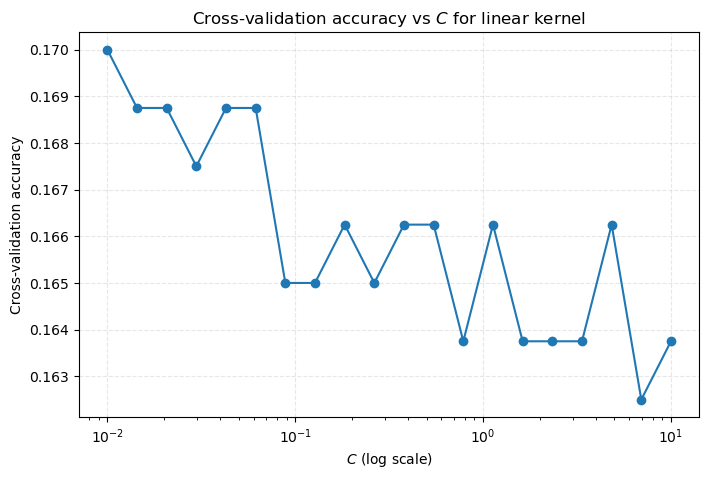

In [10]:
linear_error_rates = 1 - grid_search_linear.cv_results_["mean_test_score"]

fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogx(C_values, linear_error_rates, "-o")
ax.set_xlabel("$ C $ (log scale)")
ax.set_ylabel("Cross-validation accuracy")
ax.set_title("Cross-validation accuracy vs $ C $ for linear kernel")
ax.grid(linestyle="--", alpha=0.3)
plt.show()

__8 (e):__ The training and test error rates for the optimal model
($ C = 6.95 $) are $ 15.87\% $ and $ 18.52\% $, respectively, only a slight
improvement to the the corresponding rates of the original model ($ C = 0.01 $).

In [11]:
svc_linear_optimal = SVC(kernel="linear", C=best_C_linear)
svc_linear_optimal.fit(X_train, y_train)

y_train_pred_optimal = svc_linear_optimal.predict(X_train)
y_test_pred_optimal = svc_linear_optimal.predict(X_test)

train_error_linear_optimal = 1 - accuracy_score(y_train, y_train_pred_optimal)
test_error_linear_optimal = 1 - accuracy_score(y_test, y_test_pred_optimal)

print(f"Training error rate with optimal C: {train_error_linear_optimal:.4f}")
print(f"Test error rate with optimal C: {test_error_linear_optimal:.4f}")

Training error rate with optimal C: 0.1587
Test error rate with optimal C: 0.1852


__8 (f):__ Basically we just need to copy and paste the code for these items,
changing the kernel parameter to "rbf":

In [12]:
svm_rbf = SVC(kernel="rbf", C=0.01)
svm_rbf.fit(X_train, y_train)

n_support_rbf = svm_rbf.n_support_.sum()
print(f"RBF kernel - Number of support vectors: {n_support_rbf}")

RBF kernel - Number of support vectors: 605


In [13]:
grid_search_rbf = GridSearchCV(
    SVC(kernel="rbf"), 
    {"C": C_values}, 
    cv=5, 
    scoring="accuracy"
)
grid_search_rbf.fit(X_train, y_train)

best_C_rbf = grid_search_rbf.best_params_["C"]
print(f"RBF kernel - Optimal C value: {best_C_rbf:.4f}")

RBF kernel - Optimal C value: 0.5456


In [14]:
svm_rbf_optimal = SVC(kernel="rbf", C=best_C_rbf)
svm_rbf_optimal.fit(X_train, y_train)

y_train_pred_rbf_optimal = svm_rbf_optimal.predict(X_train)
y_test_pred_rbf_optimal = svm_rbf_optimal.predict(X_test)

train_error_rbf_optimal = 1 - accuracy_score(y_train, y_train_pred_rbf_optimal)
test_error_rbf_optimal = 1 - accuracy_score(y_test, y_test_pred_rbf_optimal)

print(f"RBF kernel - Training error rate with optimal C: {train_error_rbf_optimal:.4f}")
print(f"RBF kernel - Test error rate with optimal C: {test_error_rbf_optimal:.4f}")

RBF kernel - Training error rate with optimal C: 0.1488
RBF kernel - Test error rate with optimal C: 0.1889


The training and test error rates for the optimal SVM with radial kernel
($ C = 0.55 $) are $ 14.88\% $ and $ 18.89\% $, so while the training error
rate is slightly better than that of the optimal SVC, the test error rate
is slightly worse.

__8 (g):__

In [15]:
svm_poly = SVC(kernel="poly", degree=2, C=0.01)
svm_poly.fit(X_train, y_train)

n_support_poly = svm_poly.n_support_.sum()
print(f"Polynomial kernel - Number of support vectors: {n_support_poly}")

Polynomial kernel - Number of support vectors: 605


In [16]:
grid_search_poly = GridSearchCV(
    SVC(kernel="poly", degree=2), 
    {"C": C_values}, 
    cv=5, 
    scoring="accuracy"
)
grid_search_poly.fit(X_train, y_train)

best_C_poly = grid_search_poly.best_params_["C"]
print(f"Polynomial kernel - Optimal C value: {best_C_poly:.4f}")


Polynomial kernel - Optimal C value: 10.0000


In [17]:
svm_poly_optimal = SVC(kernel="poly", degree=2, C=best_C_poly)
svm_poly_optimal.fit(X_train, y_train)

y_train_pred_poly_optimal = svm_poly_optimal.predict(X_train)
y_test_pred_poly_optimal = svm_poly_optimal.predict(X_test)

train_error_poly_optimal = 1 - accuracy_score(y_train, y_train_pred_poly_optimal)
test_error_poly_optimal = 1 - accuracy_score(y_test, y_test_pred_poly_optimal)

print(f"Polynomial kernel - Training error rate with optimal C: {train_error_poly_optimal:.4f}")
print(f"Polynomial kernel - Test error rate with optimal C: {test_error_poly_optimal:.4f}")

Polynomial kernel - Training error rate with optimal C: 0.2100
Polynomial kernel - Test error rate with optimal C: 0.2333


__8 (h):__ Based on the test error rates, the best performance is achieved by
the support vector classifier with regularization parameter $ C = 6.95 $, closely
followed by the SVM with radial kernel and $ C = 0.55 $. The training and test
error rates for the optimal degree $ 2 $ polynomial SVM are clearly worse than
for the other two models.